# ML_project_dacon_competition : Group 8 (Hyunsoo Kim)

## 0. Import and Load

In [1]:
# connect to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### a. Import

In [3]:
import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### b. csv to parquet
- **최초 일회만** 실행 필요 -> 이후에는 parquet 형태의 데이터를 load
- 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/2022_02_machine_learning/train.csv')
test = pd.read_csv('/content/drive/MyDrive/2022_02_machine_learning/test.csv')

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

### c. Data

In [6]:
# load parquet dataset
train = pd.read_parquet('/content/drive/MyDrive/2022_02_machine_learning/train.parquet')
test = pd.read_parquet('/content/drive/MyDrive/2022_02_machine_learning/test.parquet')

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


## 1. Feature Engineering


### a. 결측치 확인

In [ ]:
# 결측치 확인
train.isna().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
road_in_use              0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [ ]:
# 결측치 확인
test.isna().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
road_in_use              0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
dtype: int64

### b. EDA 및 컬럼 분석 

Text(0.5, 1.0, 'Correlations between variables')

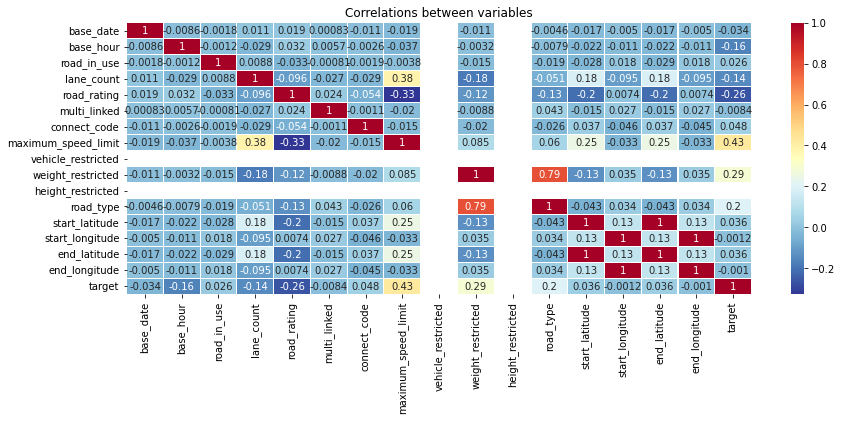

In [7]:
# 상관관계 
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=train.corr(), annot=True, cmap = plt.cm.RdYlBu_r,
            linewidths=.1, ax=ax).set_title('Correlations between variables') #상관성이 높은 컬럼들을 확인 가능  

weight_restricted와 road_type의 상관성이 0.79로 높은 수치를 보여준다.

target 변수의 값을 예측하는 대회로 상관성이 높은 maximum_speed_limit 컬럼 또한 확인 필요  

Text(0.5, 1.0, 'road_type')

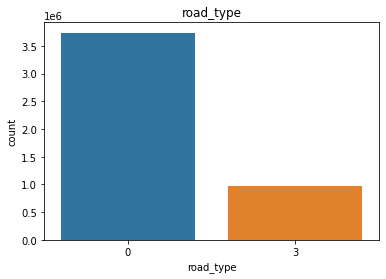

In [8]:
# road_type 
train['road_type'].value_counts()
sns.countplot(data=train, x=train['road_type']).set_title('road_type')

0은 일반 도로 3은 교량(다리)를 의미한다

Text(0.5, 1.0, 'weight_restricted')

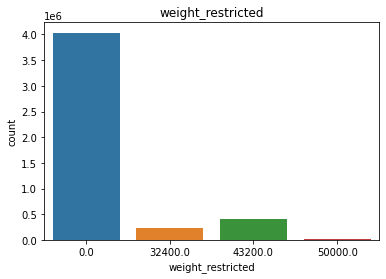

In [9]:
# weight_restricted
train['weight_restricted'].value_counts()
sns.countplot(data=train, x=train['weight_restricted']).set_title('weight_restricted')

대부분의 도로가 무게 제한이 없는 것으로 확인된다 

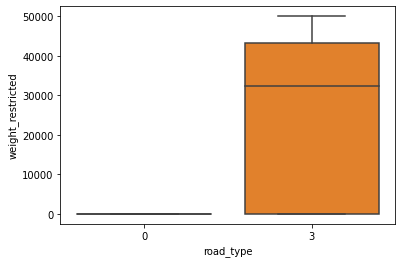

In [10]:
# 앞선 두개의 컬럼을 비교 
sns.boxplot(x='road_type',y='weight_restricted',data=train)

Text(0.5, 1.0, 'maximum_speed_limit')

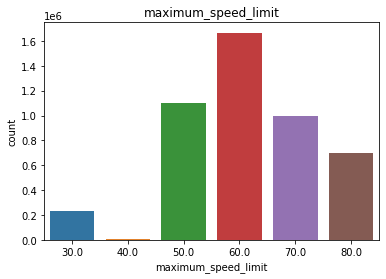

In [11]:
# maximum_speed_limit
sns.countplot(data=train, x=train['maximum_speed_limit']).set_title('maximum_speed_limit')

도로의 위치에 따라 속도의 제한이 다양하게 있음을 확인

Text(0.5, 1.0, 'speed_limit and target')

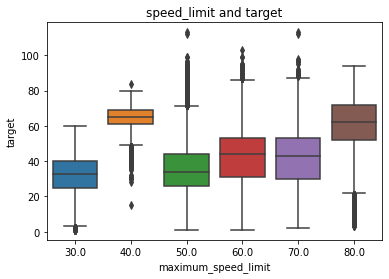

In [12]:
# speed_limit and target
sns.boxplot(x = "maximum_speed_limit", y = "target", data = train).set_title("speed_limit and target")

target 컬럼과 상관성이 높았던 속도 제한 컬럼과의 관계를 시각적으로 확인 

최대 제한 속도에 따라 평균 값의 차이가 다른 것이 확인

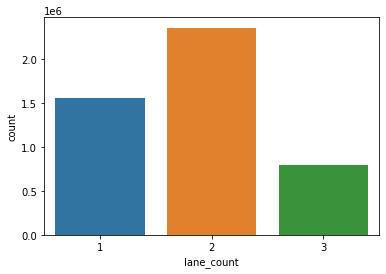

In [13]:
# lane_count
sns.countplot(data=train, x='lane_count')

도로의 차선의 개수를 시각화

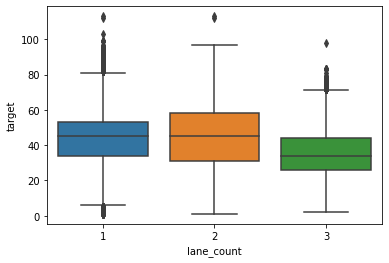

In [14]:
sns.boxplot(x = 'lane_count', y = 'target', data = train)

차선의 개수와 속도의 연관성 확인 



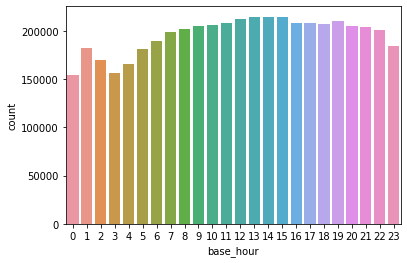

In [16]:
# base_hour
sns.countplot(data=train, x='base_hour')

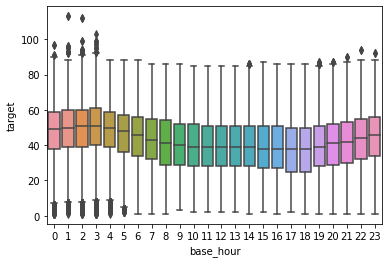

In [15]:
sns.boxplot(x ='base_hour', y = 'target', data = train)

시간과 속도에 관계 확인

낮시간보다는 야간에 평균 속도가 더 높음을 확인 

### c. 공휴일

- 21년 9월 1일 ~ 22년 7월 31일 까지의 데이터

In [ ]:
# 추출할 날짜 범위 확인  
train.groupby(["base_date"])["target"].size() 

base_date
20210901    19722
20210902    18809
20210903    19880
20210904    17998
20210905    17836
            ...  
20220727     9195
20220728     7601
20220729     5138
20220730     1845
20220731     5539
Name: target, Length: 281, dtype: int64

In [ ]:
# API를 통해서 공휴일값 csv로 
import requests
import datetime
import pandas as pd
from bs4 import BeautifulSoup
import urllib.parse as urlparse


def get_request_query(url, operation, params, serviceKey):
    params = urlparse.urlencode(params)
    request_query = url + '/' + operation + '?' + params + '&' + 'serviceKey' + '=' + serviceKey
    return request_query

mykey = 'hOPOsEJuPvGw0UKbPVJgOM1UZibEftDpAQB4EMeN8d%2BkNfgbUDW1xES3OF16ltuqNedcW20eY412HX4AKpY%2F3Q%3D%3D'
url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService'
operation = 'getRestDeInfo'

df = pd.DataFrame()

for year in [2021,2022]:
    for month in range(1,13):

        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
        params = {'solYear':year, 'solMonth':month}

        request_query = get_request_query(url, operation, params, mykey)

        res = requests.get(request_query)
        soup = BeautifulSoup(res.text, 'lxml')
        items = soup.find_all('item')

        for item in items:
            day = item.locdate.get_text()
            name = item.datename.get_text()
            data = {'dateName':name , 'locdate':day}
            df = df.append(data, ignore_index=True)
    
display(df.head())

In [ ]:
# df to csv
df_holiday = pd.DataFrame(df,columns=['locdate','dateName'])
df_holiday.to_csv('/content/drive/MyDrive/2022_02_machine_learning/holiday.csv',index=None)

In [ ]:
# holiday 데이터셋 
holiday = pd.read_csv('/content/drive/MyDrive/2022_02_machine_learning/holiday.csv')
holiday.head()

,locdate,dateName
0,20210101,1월1일
1,20210211,설날
2,20210212,설날
3,20210213,설날
4,20210301,삼일절


In [ ]:
# 공휴일과 토,일요일에 가중치 부여
def create_time_features(data):

    tmp = data.copy()

    tmp['weekend'] = tmp['day_of_week'].map({"월":0, "화":0, "수":0, "목":0, "금":0, "토":1, "일":1})

    tmp['holiday'] = tmp['base_date'].isin(holiday['locdate'].astype(int)).astype(int)
    tmp['is_holiday'] = (tmp['weekend'] + tmp['holiday']).map({0:0, 1:1, 2:1})
    tmp = tmp.drop(['weekend', 'holiday'], axis=1)
    
    tmp['month'] = tmp['base_date'].astype(str).str[4:6].astype(int)

    return tmp


train = create_time_features(train)
test = create_time_features(test)

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,is_holiday,month
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,0,6
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,0,7
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,1,10
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,0,3
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,0,10


In [ ]:
train['is_holiday'].value_counts()

0    3121708
1    1579509
Name: is_holiday, dtype: int64

### d. 위경도

In [ ]:
# 출발 위.경도와 도착 위.경도의 차이 계산산
train['lat_change'] = train['start_latitude'] - train['end_latitude']
train['lon_change'] = train['start_longitude'] - train['end_longitude']

test['lat_change'] = test['start_latitude'] - test['end_latitude']
test['lon_change'] = test['start_longitude'] - test['end_longitude']

In [ ]:
# 출발과 도착 위경도를 통한 거리
# https://www.kaggle.com/code/speedoheck/calculate-distance-with-geo-coordinates/notebook

from math import radians, cos, sin, asin, sqrt

def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = row['start_longitude']
    lat1 = row['start_latitude']
    lon2 = row['end_longitude']
    lat2 = row['end_latitude']

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

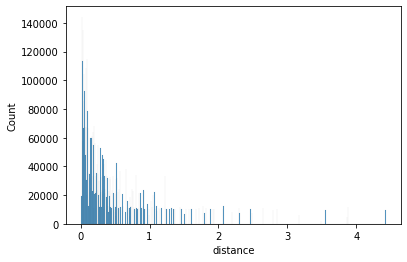

In [ ]:
# 이동 거리 
train['distance'] = train.apply(haversine, axis=1)
test['distance'] = test.apply(haversine, axis=1)
sns.histplot(data=train, x='distance')

In [ ]:
sns.histplot(data=test, x='distance')

In [ ]:
# 제주 국제 공항까지 거리
def haversine_airport(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = 126.4913534
    lat1 = 33.5104135
    lon2 = (row['start_longitude'] + row['end_longitude']) / 2
    lat2 = (row['start_latitude'] + row['end_latitude']) / 2

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

train['airport_distance'] = train.apply(haversine_airport, axis=1)
test['airport_distance'] = test.apply(haversine_airport, axis=1)

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,end_latitude,end_longitude,end_turn_restricted,target,is_holiday,month,lat_change,lon_change,distance,airport_distance
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,33.427749,126.662335,없음,52.0,0,6,-0.000001,0.000277,0.025694,18.330548
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,33.504811,126.526240,없음,30.0,0,7,-0.004081,0.002867,0.525560,3.470872
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,33.280072,126.362147,없음,61.0,1,10,-0.000927,0.006450,0.608016,28.185912
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,33.245565,126.566228,없음,20.0,0,3,0.000515,0.000976,0.107285,30.222870
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,33.462677,126.330152,없음,38.0,0,10,-0.000462,-0.003601,0.337736,16.019878


### e. 관광객 

- 제주입도 관광객 통계
https://www.jeju.go.kr/open/open/iopenboard.htm?category=1035  

In [ ]:
tourist = pd.read_csv('/content/drive/MyDrive/2022_02_machine_learning/jeju_tour.csv')
tourist

,time,tourist,year,month
0,2021/01,468016,2021,1
1,2021/02,1261784,2021,2
2,2021/03,2155110,2021,3
3,2021/04,3237971,2021,4
4,2021/05,4374423,2021,5
5,2021/06,5513290,2021,6
6,2021/07,6644802,2021,7
7,2021/08,7618996,2021,8
8,2021/09,8491392,2021,9
9,2021/10,9713486,2021,10


In [ ]:
# tourist의 추세를 확인인
fig, ax = plt.subplots(figsize=(14,5)) 
plt.xticks(rotation=45)
sns.lineplot(tourist['time'],tourist['tourist']).set_title("tourist trends")

In [ ]:
train['year'] = train['base_date'].astype(str).str[:4].astype(int)
train = train.merge(tourist[['year', 'month', 'tourist']], how='left', on=['year', 'month'])
test['year'] = test['base_date'].astype(str).str[:4].astype(int)
test = test.merge(tourist[['year', 'month', 'tourist']], how='left', on=['year', 'month'])
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,end_turn_restricted,target,is_holiday,month,lat_change,lon_change,distance,airport_distance,year,tourist
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,없음,52.0,0,6,-0.000001,0.000277,0.025694,18.330548,2022,6841854
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,없음,30.0,0,7,-0.004081,0.002867,0.525560,3.470872,2022,8105186
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,없음,61.0,1,10,-0.000927,0.006450,0.608016,28.185912,2021,9713486
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,없음,20.0,0,3,0.000515,0.000976,0.107285,30.222870,2022,3073391
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,없음,38.0,0,10,-0.000462,-0.003601,0.337736,16.019878,2021,9713486


### f. 범주형 변수 인코딩

In [ ]:
# Label Encoding
str_col = ['day_of_week', 'road_rating', 'road_type']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [ ]:
# One-hot Encoding
train = pd.get_dummies(train, columns = str_col[1:], drop_first=False)
test = pd.get_dummies(test, columns = str_col[1:], drop_first=False)

train.shape, test.shape

((4701217, 35), (291241, 34))

In [17]:
# 전처리 이후의 데이터를 parquet 형태로 튜닝시 불편함 해소
train.to_parquet('/content/drive/MyDrive/2022_02_machine_learning/train_final.parquet')
test.to_parquet('/content/drive/MyDrive/2022_02_machine_learning/test_final.parquet')

In [20]:
train = pd.read_parquet('/content/drive/MyDrive/2022_02_machine_learning/train_final.parquet')
test = pd.read_parquet('/content/drive/MyDrive/2022_02_machine_learning/test_final.parquet')
train.shape, test.shape

((4701217, 35), (291241, 34))

In [21]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_name,multi_linked,connect_code,maximum_speed_limit,...,lon_change,distance,airport_distance,year,tourist,road_rating_0,road_rating_1,road_rating_2,road_type_0,road_type_1
0,TRAIN_0000000,20220623,1,17,0,1,지방도1112호선,0,0,60.0,...,0.000277,0.025694,18.330548,2022,6841854,0,1,0,0,1
1,TRAIN_0000001,20220728,1,21,0,2,일반국도11호선,0,0,60.0,...,0.002867,0.525560,3.470872,2022,8105186,1,0,0,1,0
2,TRAIN_0000002,20211010,4,7,0,2,일반국도16호선,0,0,80.0,...,0.006450,0.608016,28.185912,2021,9713486,1,0,0,1,0
3,TRAIN_0000003,20220311,0,13,0,2,태평로,0,0,50.0,...,0.000976,0.107285,30.222870,2022,3073391,0,0,1,1,0
4,TRAIN_0000004,20211005,6,8,0,2,일반국도12호선,0,0,80.0,...,-0.003601,0.337736,16.019878,2021,9713486,1,0,0,1,0


In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target',
       'is_holiday', 'month', 'lat_change', 'lon_change', 'distance',
       'airport_distance', 'year', 'tourist', 'road_rating_0', 'road_rating_1',
       'road_rating_2', 'road_type_0', 'road_type_1'],
      dtype='object')

In [ ]:
X_train.columns

Index(['day_of_week', 'base_hour', 'road_in_use', 'lane_count', 'road_name',
       'multi_linked', 'connect_code', 'maximum_speed_limit',
       'vehicle_restricted', 'height_restricted', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude', 'is_holiday',
       'month', 'lat_change', 'lon_change', 'distance', 'airport_distance',
       'tourist', 'road_rating_0', 'road_rating_1', 'road_rating_2',
       'road_type_0', 'road_type_1'],
      dtype='object')

In [ ]:
X_train.head(2)

,day_of_week,base_hour,road_in_use,lane_count,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,height_restricted,...,lat_change,lon_change,distance,airport_distance,tourist,road_rating_0,road_rating_1,road_rating_2,road_type_0,road_type_1
0,1,17,0,1,지방도1112호선,0,0,60.0,0.0,0.0,...,-0.000001,0.000277,0.025694,18.330548,6841854,0,1,0,0,1
1,1,21,0,2,일반국도11호선,0,0,60.0,0.0,0.0,...,-0.004081,0.002867,0.525560,3.470872,8105186,1,0,0,1,0


In [22]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target', 'start_node_name', 'end_node_name',
                      'weight_restricted','year','road_in_use','road_name','multi_linked',
                      'connect_code','vehicle_restricted','height_restricted',
                      'start_turn_restricted','end_turn_restricted',
                    'road_rating_0'	,'road_rating_1'	,'road_rating_2'	,'road_type_0'	,'road_type_1'], axis=1)

X_test = test.drop(['id','base_date', 'start_node_name', 'end_node_name',
                    'weight_restricted','year','road_in_use','road_name','multi_linked',
                    'connect_code','vehicle_restricted','height_restricted',
                    'start_turn_restricted','end_turn_restricted',
                    'road_rating_0'	,'road_rating_1'	,'road_rating_2'	,'road_type_0'	,'road_type_1'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4701217, 15)
(4701217,)
(291241, 15)


### g. Standard Scaling

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

In [ ]:
X_train.head()

,day_of_week,base_hour,lane_count,maximum_speed_limit,start_latitude,start_longitude,end_latitude,end_longitude,is_holiday,month,lat_change,lon_change,distance,airport_distance,tourist,road_rating_0,road_rating_1,road_rating_2,road_type_0,road_type_1
0,-0.991029,0.754498,-1.216503,-0.103292,0.429152,0.901272,0.429179,0.899511,-0.711320,-0.079493,0.000045,0.046598,-0.718302,-0.201502,0.103804,-0.921754,1.974764,-0.712237,-1.968826,1.968826
1,-0.991029,1.349551,0.237511,-0.103292,1.150320,0.047471,1.190706,0.029071,-0.711320,0.185615,-0.953289,0.465754,0.125415,-1.562515,0.450671,1.084888,-0.506390,-0.712237,0.507917,-0.507917
2,0.507489,-0.733134,0.237511,1.545032,-1.039228,-0.979027,-1.030152,-1.020437,1.405837,0.980939,-0.216243,1.045772,0.264592,0.701161,0.892253,1.084888,-0.506390,-0.712237,0.507917,-0.507917
3,-1.490536,0.159445,0.237511,-0.927454,-1.365944,0.291115,-1.371145,0.284828,-0.711320,-0.874818,0.120858,0.159741,-0.580587,0.887728,-0.930884,-0.921754,-0.506390,1.404026,0.507917,-0.507917
4,1.506502,-0.584371,0.237511,1.545032,0.769731,-1.247926,0.774335,-1.225076,-0.711320,0.980939,-0.107672,-0.581047,-0.191610,-0.413138,0.892253,1.084888,-0.506390,-0.712237,0.507917,-0.507917


In [24]:
# train_test_split
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                            stratify=train['base_hour'], random_state=42) #stratify는 base_hour 컬럼의 시간의 바율을 맞춰서 분리

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 15) (3760973,)
(940244, 15) (940244,)


## 2. Modeling

In [ ]:
# optuna 설치 
!pip install optuna

In [29]:
# Optuna Libraries
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# LGBM Regressor
from lightgbm import LGBMRegressor

# train_test_split
from sklearn.model_selection import train_test_split

# Evaluation Score
from sklearn.metrics import mean_squared_error

### a. LigthGBM

In [25]:
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_tr,y_tr)

LGBMRegressor(random_state=42)

In [27]:
from sklearn.metrics import mean_absolute_error
val_pred = lgb_model.predict(X_tr)
print('MSE : {:.6f}'.format(mean_absolute_error(y_tr,val_pred))) #훈련 

MSE : 4.494868


In [ ]:
from sklearn.metrics import mean_absolute_error
val_pred = lgb_model.predict(X_val)
print('MSE : {:.6f}'.format(mean_absolute_error(y_val,val_pred))) #검증 

MSE : 3.560010


In [ ]:
# optuna로 최적의 파라미터 검색  
# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    lgbm_param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'mae', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 200, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 10.0, 20.0),
    }

    # Generate model
    model_lgbm = LGBMRegressor(**lgbm_param)
    model_lgbm = model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                           verbose=0, early_stopping_rounds=25)
                           
    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하면 된다.                         
    MAE = mean_absolute_error(y_val, model_lgbm.predict(X_val))
    return MAE

optuna_lgbm = optuna.create_study(direction='minimize', sampler=sampler)

# * n_trials의 경우 optuna를 몇번 실행하여 hyper parameter를 찾을 것인지를 정한다.
# 50으로 설정해도 유의미한 값이 나온다.
optuna_lgbm.optimize(objective, n_trials=100)

In [ ]:
lgbm_trial = optuna_lgbm.best_trial
lgbm_trial_params = lgbm_trial.params
print('Best Trial: score {},\nparams {}'.format(lgbm_trial.value, lgbm_trial_params))

In [ ]:
lgb_model = lgb.LGBMRegressor(n_estimators=18000, 
                              num_leaves = 128,
                              colsample_bytree=0.6,
                              reg_lambda=16,
                              random_state=42)


lgb_model.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='l1',
                verbose=500,
                early_stopping_rounds=30) #조기종류의 조건을 걸어서 과적합 방지  

### b. XGBoost

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=500, random_state=42)
xgb_model.fit(X_tr, y_tr)    

[07:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
from sklearn.metrics import mean_absolute_error
val_pred = xgb_model.predict(X_tr)
print('MSE : {:.6f}'.format(mean_absolute_error(y_tr,val_pred))) #훈련 

In [ ]:
from sklearn.metrics import mean_absolute_error
val_pred = xgb_model.predict(X_val)
print('MSE : {:.6f}'.format(mean_absolute_error(y_val,val_pred))) #검증 

### c. CatBoost

In [ ]:
!pip install catboost 

In [ ]:
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor()
cb_model.fit(X_tr,y_tr)

In [ ]:
# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'max_depth': trial.suggest_int('max_depth',1, 15),
    }

    # Generate model
    model_cbrm = CatBoostRegressor(**cbrm_param)
    model_cbrm = model_cbrm.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                           verbose=0, early_stopping_rounds=25)
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    MAE = mean_absolute_error(y_val, model_cbrm.predict(X_val))
    return MAE 

optuna_cbrm = optuna.create_study(direction='minimize', sampler=sampler)
optuna_cbrm.optimize(objective, n_trials=50)

In [ ]:
cbrm_trial = optuna_cbrm.best_trial
cbrm_trial_params = cbrm_trial.params
print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

In [ ]:
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor(iterations=10000,
                             max_depth=8,
                             learning_rate=0.4,
                             eval_metric='MAE',
                             random_state=42)
cb_model.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=500,
                early_stopping_rounds=30)  

In [ ]:
from sklearn.metrics import mean_absolute_error
val_pred = cb_model.predict(X_val)
print('MSE : {:.6f}'.format(mean_absolute_error(y_val,val_pred))) #검증 

In [ ]:
from sklearn.metrics import mean_absolute_error
val_pred = cb_model.predict(X_tr)
print('MSE : {:.6f}'.format(mean_absolute_error(y_tr,val_pred))) #훈련 

## 3. Predict and Submit

### a. Pred

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/2022_02_machine_learning/sample_submission.csv')

In [ ]:
pred_lgb = lgb_model.predict(X_test)
sample_submission_lgb = sample_submission.copy()
sample_submission_lgb['target'] = pred_lgb  

In [ ]:
pred_xgb = xgb_model.predict(X_test)
sample_submission_xgb = sample_submission.copy()
sample_submission_xgb['target'] = pred_xgb

In [ ]:
pred_cb = cb_model.predict(X_test)
sample_submission_cb = sample_submission.copy()
sample_submission_cb['target'] = pred_cb  

### b. Submit

In [ ]:
#sample_submission['target'] = ((sample_submission_lgb['target'] + sample_submission_xgb['target']) / 2)

In [ ]:
sample_submission['target'] = ((sample_submission_lgb['target']*0.8 + sample_submission_cb['target']*0.2))

In [ ]:
#sample_submission['target'] = ((sample_submission_lgb['target'] + sample_submission_xgb['target'] + sample_submission_cb['target']) / 3)

In [ ]:
sample_submission.to_csv("/content/drive/MyDrive/dacon/data/submit.csv", index = False)

In [ ]:
sample_submission